# Pós Graduação em Ciência de Dados - 2022.2
## IFSP Campinas

### Projeto Interdisciplinar Big Data + ML

#### 

Profa. Bianca Pedrosa - bpedrosa@ifsp.edu.br <br>
Prof. Samuel Martins (Samuka) - @hisamuka

Outubro de 2022

* aluno: Swift Yaguchi - CP301665X

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>. <br/><br/>
##### -----------------------------------------------

## 1. Introdução
Este projeto apresenta um estudo de análise de Machine Learning usando a plataforma AWS.

O projeto teve como inspiração um estudo feito sobre o "Titanic Problem" na plataforma do Kaggle:

No "Titanic Problem" os dados referente aos passageiros do navio foram base para identificar característcias dos sobreviventes do naufráfio.

Neste projeto, o estudo foi adaptado para analisar dados referente aos cadndiatos da última eleição brasileira de 2022 para identificar características dos candidiatos eleitos.

### 1.1 Referências:
https://www.kaggle.com/code/odaymourad/detailed-and-typical-solution-ensemble-modeling
https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling



## 2. Detalhes dos Dados 
A base de dados escolhido foi extraido do conjunto de dados do Portal de Dados Abertos do TSE onde sao disponibilizados à sociedade dados gerados ou custodiados pelo TSE, de forma a garantir o acesso a informacoes e aprimorar a cultura de transparência. <br>
Este portal substitui o antigo Repositorio de Dados Eleitorais, descontinuado em janeiro de 2022, e esta em constante atualizacao segundo minha observacao. <br>
Segundo o proprio site do TSE, os dados la disponiveis podem ser livremente acessados, utilizados, modificados e compartilhados por qualquer pessoa, com vistas à geracao de novas informacoes e iniciativas da sociedade que busquem estimular o controle social e contribuir com a melhoria da gestao pulica. <br>
(https://dadosabertos.tse.jus.br/) <br><br>
O portal contem uma enormidade de dados relativos às eleicoes brasileiras como resultados detalhados de votacao das ltimas eleicoes, pesquisas eleitorais, prestacao de contas dos candidatos, perfil de eleitores, assim como dados antigos como candidatos de eleicoes antigas desde o ano de 1933. <br><br>

A partir desses dados foi feito um trabalho de selecao e limpeza de dados para cada um dos arquivos acima:
- convertendo a codificacao de caracteres dos arquivos de dados de "Latin 1" para "UTF-8"
- não foram considerados dados de candidiatos para presidente e governador, mas sim todos os demais cargos, senador, deputado federal e deputado estadual.


### 2.1 Referências:
Especificamente para este trabalho foram selecionados os seguinte dados referentes ao primeiro turno da eleicao corrente de 2022:
- Resultados de votacao por municipio e por zona (830.299KB zip) https://dadosabertos.tse.jus.br/dataset/resultados-2022/resource/40fdcf49-256a-4c81-87cf-711545bd1528 
- Perfil dos candidatos (5.986KB zip) https://dadosabertos.tse.jus.br/dataset/candidatos-2022/resource/435145fd-bc9d-446a-ac9d-273f585a0bb9




## 3. Arquitetura

Este notebook foi originalmente desenvolvido no ambiente do Google Colab e no ambiente local do meu computador.<br>
Posteriormente foi carregado no AWS Sagemaker.<br>
A figura ilustra este fluxo.<br>
No AWS os dados foram carregados num bucket S3: "syaguchi-ifspcps-projinter2022-2-awsbucket"


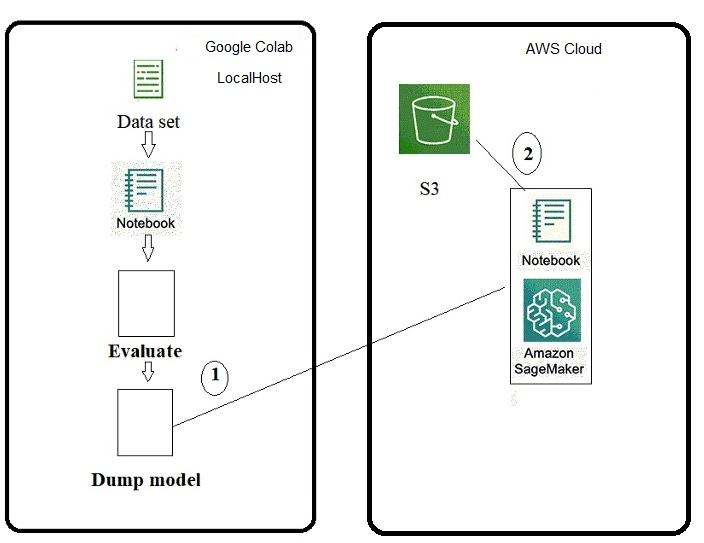

O fluxo de desenvolviemnto deste projeto seguiu basicamente o seguinte pipeline:

![SageMaker Pipelines](images/sm-pipelines.png "SageMaker Pipelines")

## 4. Infra-estrutura

A configuração do notebook a seguir ilustra a infra-estrutura para o projeto:


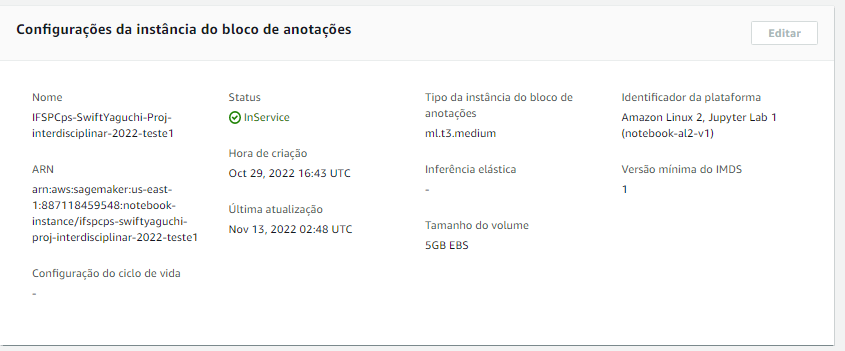

## 5. Set-up

In [1]:
#=======================================================================================
# Importing the libaries:
#=======================================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")

import boto3
import io


#=======================================================================================

In [2]:
import sagemaker as sage
from sagemaker import get_execution_role

role = get_execution_role()

# Create session - The session remembers our connection parameters to Amazon SageMaker. We'll use it to perform all of our Amazon SageMaker operations.
sagemaker_session = sage.Session()

### 5.1. Limpeza e Pré-processamento de Dados

Os dados brutos extraídos do site de dados abertos do TSE foram tratados com limpeza e pré-processamento em dois notebooks separados deste:

- tse_2022 limpeza_e_preprocessamento_de_dados_TSE VotaçãoEleição2022 v1
- tse_2022 preprocessamento_de_dados_TSE VotaçãoEleição2022 v1

Os dados do TSE são de grande volume, mas não apresentam dados nulos, e todas as variáveis categóricas já tem campo de variável numérica correspondente, facilitando e não necessitando usar técnicas de limpeza de dados.

### 5.2. Importando os dados:

In [2]:
#=======================================================================================
# Reading the data (for Google Colab and Localhost computer )
#=======================================================================================

def read_data():
    # train_data = pd.read_csv("gdrive/My Drive/IFSP-CMP-D2APR-2022.2/ProjInter_20022.2/datasets TSE/tse_2022_train_sprint-3.csv")
    train_data = pd.read_csv("./datasets TSE/tse_2022_train_sprint-3.csv")
    print("Train data imported successfully!!")
    print("-"*50)
    # test_data = pd.read_csv("gdrive/My Drive/IFSP-CMP-D2APR-2022.2/ProjInter_20022.2/datasets TSE/tse_2022_test_sprint-3.csv")
    test_data = pd.read_csv("./datasets TSE/tse_2022_test_sprint-3.csv")                         
    print("Test data imported successfully!!")
    return train_data , test_data

train_data , test_data = read_data()
combine = [train_data , test_data]

#=======================================================================================

Train data imported successfully!!
--------------------------------------------------
Test data imported successfully!!


In [3]:
#=======================================================================================
# Reading the data (for AWS S3 )
#=======================================================================================

s3_client = boto3.client("s3")
data_bucket_name = "syaguchi-ifspcps-projinter2022-2-awsbucket"
obj_list = s3_client.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)

['scikitlearn-tse-2022-train-from-boto3/source.tar.gz', 'tse_2022_test_sprint-3.csv', 'tse_2022_train_sprint-3.csv', 'votacao_candidato_munzona_2022_BRASIL_pre_merge4.csv']


In [4]:
file_data = 'tse_2022_train_sprint-3.csv'
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
train_data = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [5]:
file_data = 'tse_2022_test_sprint-3.csv'
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
test_data = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

### 5.3. Verificando os dados:

In [6]:
train_data.head()

,CD_CARGO,SQ_CANDIDATO,NR_IDADE_DATA_POSSE_x,CD_GENERO,CD_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,CD_COR_RACA,CD_OCUPACAO,ST_REELEICAO_x,VR_BEM_CANDIDATO_x,QT_VOTOS_NOMINAIS_x,DS_SIT_TOT_TURNO
0,7,250001620658,45.0,2,8,1,1,297,0,380095.0,3164,0
1,7,250001699839,46.0,2,6,1,3,923,0,7000.0,264,0
2,7,250001737624,57.0,4,6,1,2,999,0,750000.0,777,0
3,6,130001634132,38.0,2,5,1,2,512,0,250000.0,115,0
4,6,270001700071,36.0,4,8,3,2,102,0,745000.0,1073,0


In [7]:
test_data.head()

,CD_CARGO,SQ_CANDIDATO,NR_IDADE_DATA_POSSE_x,CD_GENERO,CD_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,CD_COR_RACA,CD_OCUPACAO,ST_REELEICAO_x,VR_BEM_CANDIDATO_x,QT_VOTOS_NOMINAIS_x,DS_SIT_TOT_TURNO
0,7,160001717443,57.0,2,6,1,1,297,0,38750.00,1975,0
1,7,160001723054,78.0,2,8,3,1,131,0,1671394.53,858,0
2,7,250001621417,59.0,2,4,1,1,125,0,10000.00,286,0
3,6,100001602261,41.0,2,8,3,3,131,1,6527842.31,71999,0
4,6,50001605373,33.0,2,8,1,1,131,0,117849.69,29801,0


In [8]:
#=======================================================================================
# Discovering the features:
#=======================================================================================

print("Train data features are:\n")
print(train_data.columns.values)
print('\n' ,"="*80 , '\n')
print("Test data features are:\n")
print(test_data.columns.values)

Train data features are:

['CD_CARGO' 'SQ_CANDIDATO' 'NR_IDADE_DATA_POSSE_x' 'CD_GENERO'
 'CD_GRAU_INSTRUCAO' 'CD_ESTADO_CIVIL' 'CD_COR_RACA' 'CD_OCUPACAO'
 'ST_REELEICAO_x' 'VR_BEM_CANDIDATO_x' 'QT_VOTOS_NOMINAIS_x'
 'DS_SIT_TOT_TURNO']


Test data features are:

['CD_CARGO' 'SQ_CANDIDATO' 'NR_IDADE_DATA_POSSE_x' 'CD_GENERO'
 'CD_GRAU_INSTRUCAO' 'CD_ESTADO_CIVIL' 'CD_COR_RACA' 'CD_OCUPACAO'
 'ST_REELEICAO_x' 'VR_BEM_CANDIDATO_x' 'QT_VOTOS_NOMINAIS_x'
 'DS_SIT_TOT_TURNO']


In [9]:
#=======================================================================================
# Discovering the features types:
#=======================================================================================

train_data.info()
print('_'*40 , '\n')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13165 entries, 0 to 13164
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CD_CARGO               13165 non-null  int64  
 1   SQ_CANDIDATO           13165 non-null  int64  
 2   NR_IDADE_DATA_POSSE_x  13165 non-null  float64
 3   CD_GENERO              13165 non-null  int64  
 4   CD_GRAU_INSTRUCAO      13165 non-null  int64  
 5   CD_ESTADO_CIVIL        13165 non-null  int64  
 6   CD_COR_RACA            13165 non-null  int64  
 7   CD_OCUPACAO            13165 non-null  int64  
 8   ST_REELEICAO_x         13165 non-null  int64  
 9   VR_BEM_CANDIDATO_x     13165 non-null  float64
 10  QT_VOTOS_NOMINAIS_x    13165 non-null  int64  
 11  DS_SIT_TOT_TURNO       13165 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1.2 MB
________________________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3292 entries, 0 to 

Aparentemente não há variáveis com dados nulos

In [11]:
#=======================================================================================
# Discovering the train data distribution :
#=======================================================================================

train_data.describe()

,CD_CARGO,SQ_CANDIDATO,NR_IDADE_DATA_POSSE_x,CD_GENERO,CD_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,CD_COR_RACA,CD_OCUPACAO,ST_REELEICAO_x,VR_BEM_CANDIDATO_x,QT_VOTOS_NOMINAIS_x,DS_SIT_TOT_TURNO
count,13165.000000,1.316500e+04,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000,1.316500e+04,1.316500e+04,13165.000000
mean,6.614964,1.566632e+11,49.457425,2.557539,7.244360,3.330270,1.814052,365.286213,0.073908,9.873539e+05,1.932430e+04,0.092366
std,0.553658,7.265737e+10,11.005859,0.896822,1.231515,2.422484,0.972065,298.425643,0.261631,5.932901e+06,1.561025e+05,0.289553
min,5.000000,1.000160e+10,20.000000,2.000000,2.000000,1.000000,1.000000,101.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,6.000000,1.000016e+11,42.000000,2.000000,6.000000,1.000000,1.000000,155.000000,0.000000,7.641947e+04,4.900000e+02,0.000000
50%,7.000000,1.600016e+11,49.000000,2.000000,8.000000,3.000000,1.000000,257.000000,0.000000,2.700000e+05,1.858000e+03,0.000000
75%,7.000000,2.200016e+11,57.000000,4.000000,8.000000,3.000000,3.000000,298.000000,0.000000,7.360838e+05,9.067000e+03,0.000000
max,8.000000,2.700017e+11,90.000000,4.000000,8.000000,9.000000,6.000000,999.000000,1.000000,4.484474e+08,1.071491e+07,1.000000


In [12]:
train_data_DS_SIT_TOT_TURNO_count = train_data['DS_SIT_TOT_TURNO'].value_counts()
print(train_data_DS_SIT_TOT_TURNO_count)

0    11949
1     1216
Name: DS_SIT_TOT_TURNO, dtype: int64


In [13]:
# proportional of the groups in the entire dataset
train_data_DS_SIT_TOT_TURNO_count = train_data['DS_SIT_TOT_TURNO'].value_counts() / len(train_data['DS_SIT_TOT_TURNO'])
print(train_data_DS_SIT_TOT_TURNO_count)

0    0.907634
1    0.092366
Name: DS_SIT_TOT_TURNO, dtype: float64


#### Numerical data distribution discovering results:
  - Os eleitos são apenas 9,2%.
  - 



### 5.3 Exploratory Data Analysis (EDA):

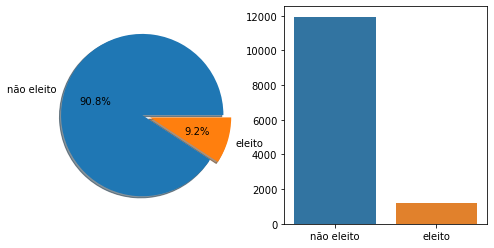

In [14]:
# ===================================================================
# Contagem dos eleitos
# ===================================================================


f,ax=plt.subplots(1,2,figsize=(8,4))
train_data['DS_SIT_TOT_TURNO'].replace({0:"não eleito", 1:"eleito"}).value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x = train_data["DS_SIT_TOT_TURNO"].replace({0:"não eleito",1:"eleito"}) , ax = ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.show()

Apenas 9,2% dos candidtos são eleitos


<div style="color:black;
           border-radius:0px;
           background-color:#00ADB5;
           font-size:14px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px;
              color:white;">
            <b>Discovering the features correlation with "Eleitos":</b>
        </p>
</div>


In [15]:
# Helper functions:
def elected_bar_plot(feature):
    plt.figure(figsize = (20,4))
    sns.barplot(data = train_data , x = feature , y = "DS_SIT_TOT_TURNO").set_title(f"{feature} Vs DS_SIT_TOT_TURNO")
    plt.show()
def elected_table(feature):
    return train_data[[feature, "DS_SIT_TOT_TURNO"]].groupby([feature], as_index=False).mean().sort_values(by='DS_SIT_TOT_TURNO', ascending=False).style.background_gradient(low=0.75,high=1)
def elected_hist_plot(feature):
    plt.figure(figsize = (20,4))
    sns.histplot(data = train_data , x = feature , hue = "DS_SIT_TOT_TURNO",binwidth=5,palette = sns.color_palette(["yellow" , "green"]) ,multiple = "stack" ).set_title(f"{feature} Vs DS_SIT_TOT_TURNO")
    plt.show()

#### Gênero Vs Eleito:
- 4 FEMININO
- 2 MASCULINO


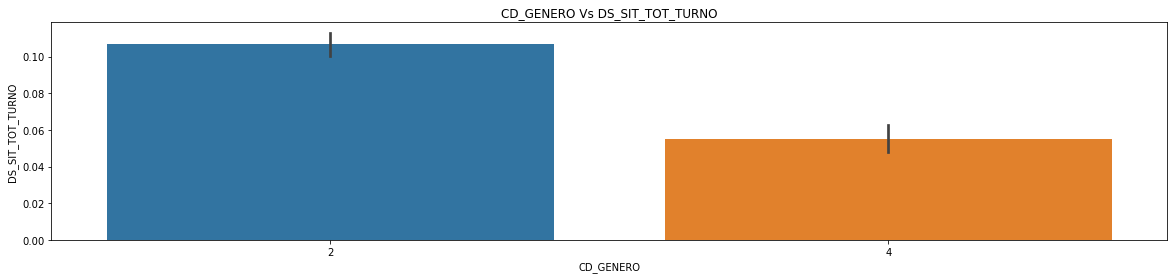

In [16]:
elected_bar_plot('CD_GENERO')

In [17]:
elected_table('CD_GENERO')

,CD_GENERO,DS_SIT_TOT_TURNO
0,2,0.106793
1,4,0.055041


Candidatos masculinos tem maior taxa de serem eleitos, 10,6 % contra 5,5% femininos

#### Grau de instrução Vs Eleitos:
- 2 LE E ESCREVE
- 3 ENSINO FUNDAMENTAL INCOMPLETO
- 4 ENSINO FUNDAMENTAL COMPLETO
- 5 ENSINO MEDIO INCOMPLETO
- 6 ENSINO MEDIO COMPLETO
- 7 SUPERIOR INCOMPLETO
- 8 SUPERIOR COMPLETO

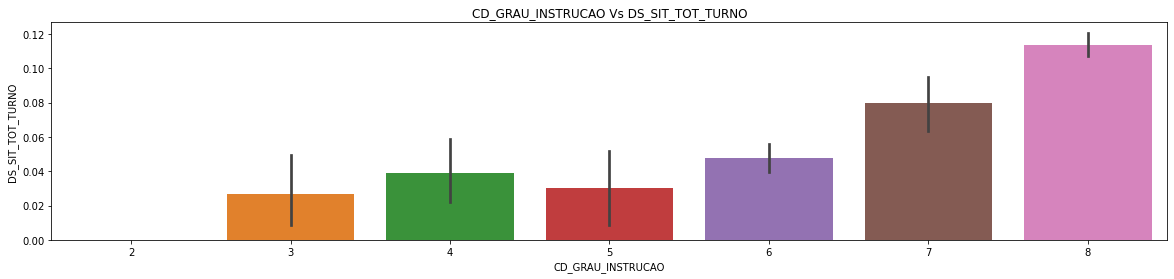

In [18]:
elected_bar_plot("CD_GRAU_INSTRUCAO")

In [19]:
elected_table('CD_GRAU_INSTRUCAO')

,CD_GRAU_INSTRUCAO,DS_SIT_TOT_TURNO
6,8,0.113652
5,7,0.079782
4,6,0.047506
2,4,0.039024
3,5,0.030172
1,3,0.026906
0,2,0.000000


Candidatos com grau de instrução superior, completos ou incompletos, tem maior taxa de serem eleitos

#### DS_ESTADO_CIVIL:
- 1	SOLTEIRO(A)
- 3	CASADO(A)
- 5	VIUVO(A)
- 7	SEPARADO(A) JUDICIALMENTE
- 9	DIVORCIADO(A)

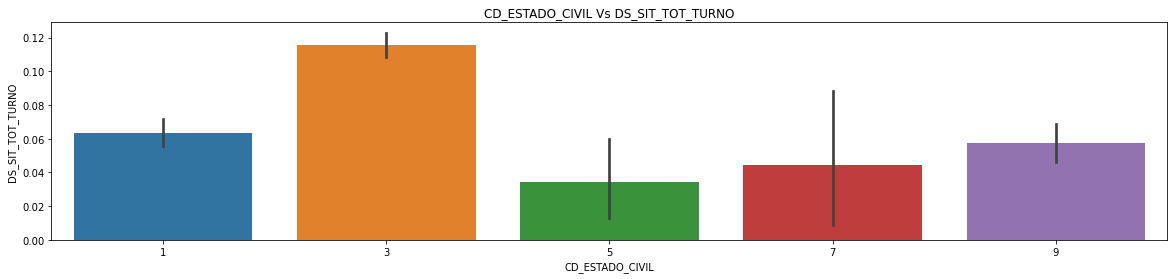

In [20]:
elected_bar_plot("CD_ESTADO_CIVIL")

In [21]:
elected_table('CD_ESTADO_CIVIL')

,CD_ESTADO_CIVIL,DS_SIT_TOT_TURNO
1,3,0.115828
0,1,0.063565
4,9,0.057391
3,7,0.044248
2,5,0.034188


Candidiatos casados tem maior taxa de serem eleitos

#### DS_COR_RACA:
- 1	BRANCA
- 2	PRETA
- 3	PARDA
- 4	AMARELA
- 5	INDIGENA
- 6	NAO INFORMADO

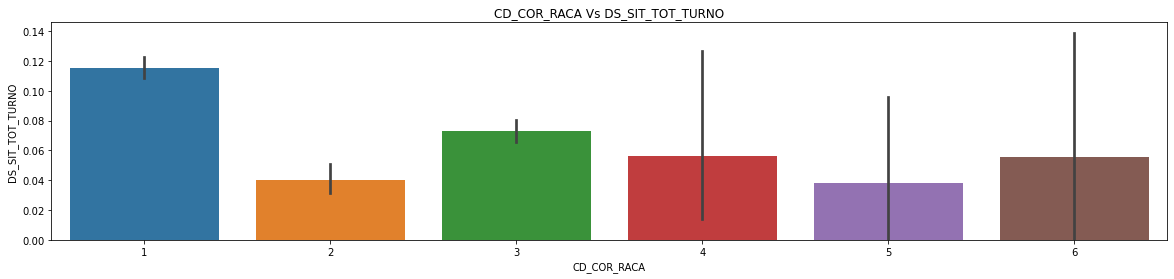

In [22]:
elected_bar_plot("CD_COR_RACA")

In [23]:
elected_table("CD_COR_RACA")

,CD_COR_RACA,DS_SIT_TOT_TURNO
0,1,0.115246
2,3,0.073075
3,4,0.056338
5,6,0.055556
1,2,0.040278
4,5,0.038462


Candidiatos brancos tem maior taxa de serem eleitos

#### ST_REELEICAO:
- 0  não é candidato a reeleição
- 1  é candidato a reeleição

In [24]:
elected_table("ST_REELEICAO_x")

,ST_REELEICAO_x,DS_SIT_TOT_TURNO
1,1,0.680370
0,0,0.045440


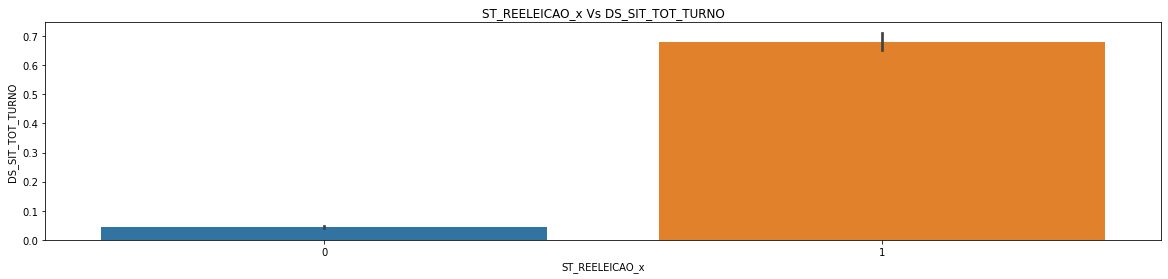

In [25]:
elected_bar_plot("ST_REELEICAO_x")

Candidatos à reeleição tem taxas disparadamente maiores de serem eleitos

#### NR_IDADE_DATA_POSSE:

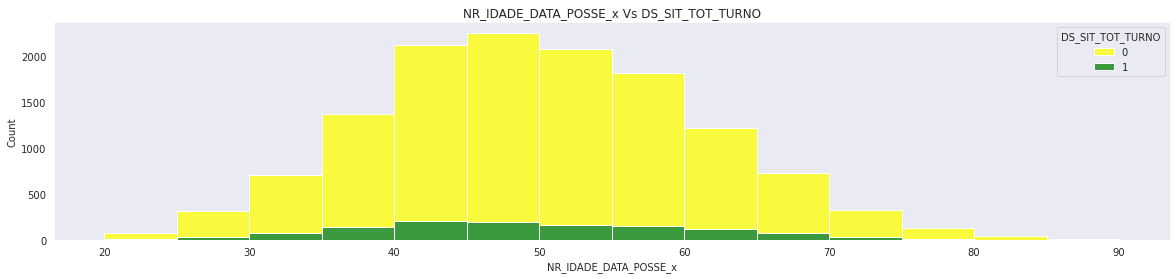

In [26]:
sns.set_style("dark") # to remove the grid.
elected_hist_plot('NR_IDADE_DATA_POSSE_x') # Note: This plot is stack plot.

- grande parte dos candidatos estão na faixa de idade entre 40 e 60 anos, e são os mais eleitos 

<div style="color:black;
           border-radius:0px;
           background-color:#00ADB5;
           font-size:14px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 6px;
              color:white;">
            <b>Discovering the correlation between the features:</b>
        </p>
</div>


<AxesSubplot:>

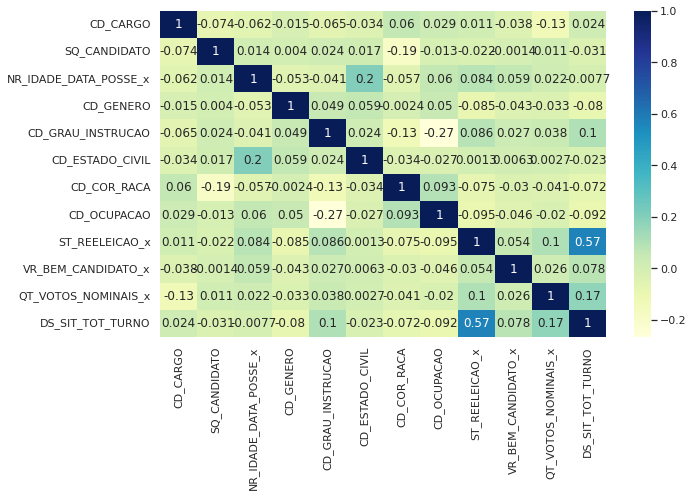

In [27]:
#=======================================================================================
# Discovering the correlations:
#=======================================================================================

sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(train_data.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

- candidatos à reeleição tem maior taxa de serem eleitos
- estado civil e cor da raça não tem correlação positiva com serem eleitos

In [10]:
# estudo eliminando a variável QT_VOTOS_NOMINAIS_x
train_data_2 = train_data.drop(columns=['QT_VOTOS_NOMINAIS_x'])
test_data_2 = test_data.drop(columns=['QT_VOTOS_NOMINAIS_x'])
Test = test_data.drop(columns=['QT_VOTOS_NOMINAIS_x'])

## 6. Modeling:

#### 6.1. Cross validate models

In [11]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve



In [12]:
# ==================================================================================
# Preparing Data For Training:
# ==================================================================================

Y_train = train_data_2["DS_SIT_TOT_TURNO"]
X_train = train_data_2.drop(labels = ["DS_SIT_TOT_TURNO"],axis = 1)

print(f"X_train shape is = {X_train.shape}" )
print(f"Y_train shape is = {Y_train.shape}" )
print(f"Test shape is = {Test.shape}" )

X_train shape is = (13165, 10)
Y_train shape is = (13165,)
Test shape is = (3292, 11)


In [13]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

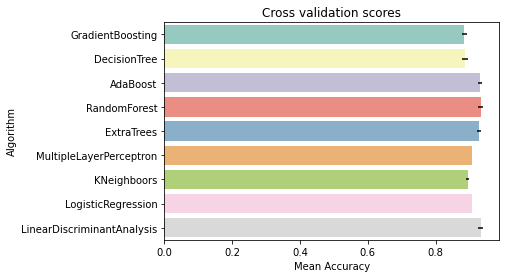

In [14]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["GradientBoosting","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [15]:
cv_res.sort_values(by='CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
8,0.933992,0.007103,LinearDiscriminantAnalysis
3,0.933385,0.006939,RandomForest
2,0.931865,0.005090,AdaBoost
4,0.928523,0.005194,ExtraTrees
7,0.907634,0.000344,LogisticRegression
5,0.907406,0.000963,MultipleLayerPerceptron
6,0.894493,0.003329,KNeighboors
1,0.886897,0.008041,DecisionTree
0,0.885378,0.007638,GradientBoosting


#### 6.2 Hyperparameter tunning for best models

In [16]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8919106124493126

In [25]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.9332325354898418

In [22]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.9351316545616939

In [23]:
# LinearDiscriminantAnalysis tunning

LDA = LinearDiscriminantAnalysis()

lda_parameters = {
    'solver': ['lsqr'],
    'shrinkage': [None] + [x / 10 for x in range(0, 11)] + ['auto'],
    'n_components': [None] + [1, 2, 5, 8, 13, 21, 34, 55],
    'store_covariance': [True, False],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}
gsLDA = GridSearchCV(LDA, lda_parameters, cv=5, verbose=1, n_jobs=-4)
gsLDA.fit(X_train, Y_train)

LDA_best = gsLDA.best_estimator_

# Best score
gsLDA.best_score_


Fitting 5 folds for each of 3276 candidates, totalling 16380 fits


0.9076338777060388

In [24]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.934372122328309

In [26]:
df1=pd.DataFrame(gsadaDTC.cv_results_)
#df1.head()

In [27]:
df2=pd.DataFrame(gsRFC.cv_results_)
#df2.head()

In [28]:
df3=pd.DataFrame(gsGBC.cv_results_)
#df3.head()

In [29]:
df4=pd.DataFrame(gsLDA.cv_results_)
#df4.head()

In [30]:
df5=pd.DataFrame(gsExtC.cv_results_)
#df5.head()

In [31]:
# saving results
# if you want to keep the reference for the row indices from the original dataset, remove the index=False
df1.to_csv('./datasets TSE/gsadaDTC_cv_results_.csv', index=False)
df2.to_csv('./datasets TSE/gsRFC_cv_results_.csv', index=False)
df3.to_csv('./datasets TSE/gsGBC_cv_results_.csv', index=False)
df4.to_csv('./datasets TSE/gsLDA_cv_results_.csv', index=False)
df5.to_csv('./datasets TSE/gsExtC_cv_results_.csv', index=False)


#### 6.3. Plot learning curves
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

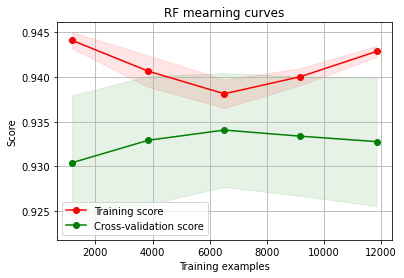

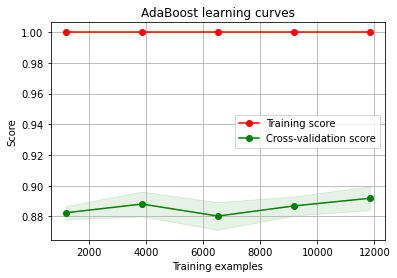

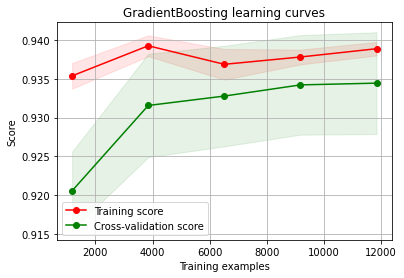

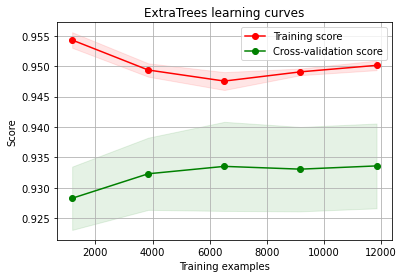

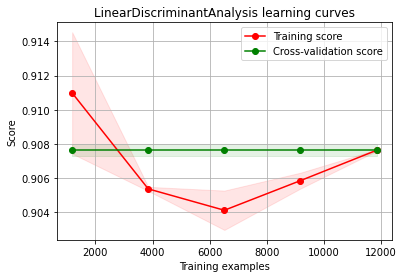

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLDA.best_estimator_,"LinearDiscriminantAnalysis learning curves",X_train,Y_train,cv=kfold)

#### 6.4. Feature importance of tree based classifiers
In order to see the most informative features for the prediction of cadidates election rate, i displayed the feature importance for the 4 tree based classifiers.

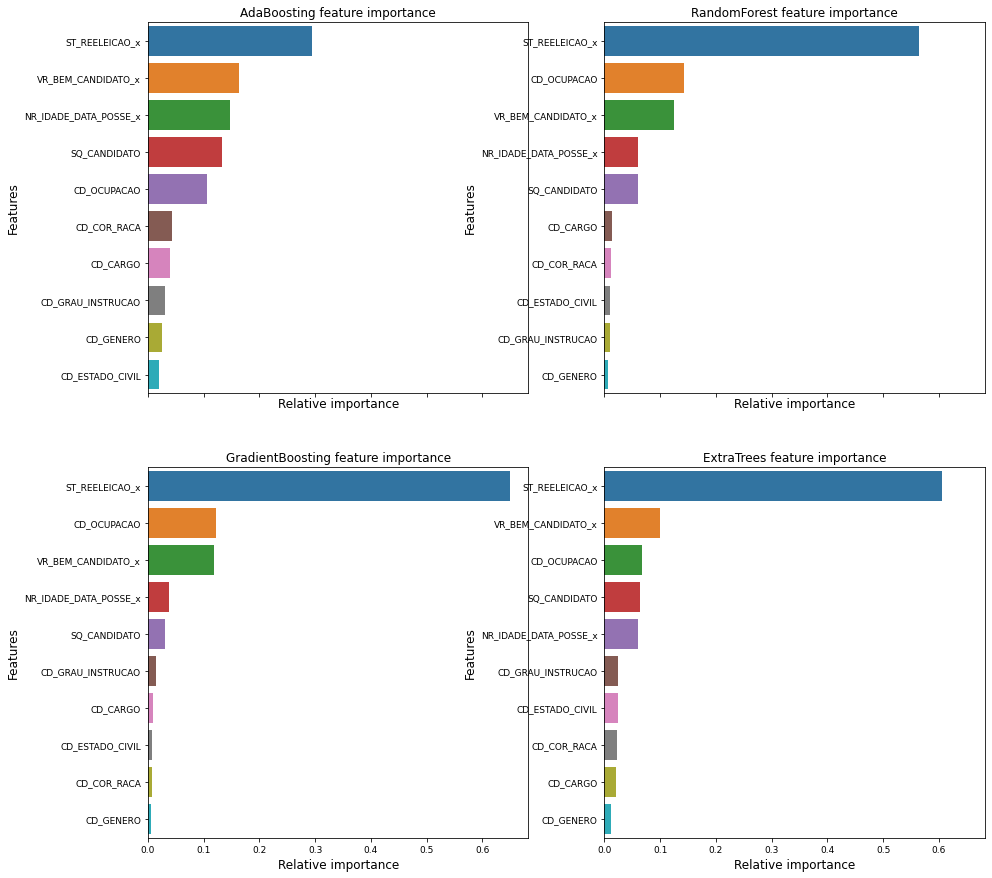

In [33]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best),("ExtraTrees",ExtC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:10]
        g = sns.barplot(y=X_train.columns[indices][:10],x = classifier.feature_importances_[indices][:10] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

Interessante observar que cada modelo tem feature de maior importância diferentes, AdaBoosting e Extra Trees tem VR_BEM_CANDIDATO com importância relativa maior que CD_OCUPACAO, e Random Forest e Gradient Boosting o contrário.

In [44]:
Test = test_data.drop(labels = ["QT_VOTOS_NOMINAIS_x","DS_SIT_TOT_TURNO"],axis = 1)

In [45]:
Test.head()

,CD_CARGO,SQ_CANDIDATO,NR_IDADE_DATA_POSSE_x,CD_GENERO,CD_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,CD_COR_RACA,CD_OCUPACAO,ST_REELEICAO_x,VR_BEM_CANDIDATO_x
0,7,160001717443,57.0,2,6,1,1,297,0,38750.00
1,7,160001723054,78.0,2,8,3,1,131,0,1671394.53
2,7,250001621417,59.0,2,4,1,1,125,0,10000.00
3,6,100001602261,41.0,2,8,3,3,131,1,6527842.31
4,6,50001605373,33.0,2,8,1,1,131,0,117849.69


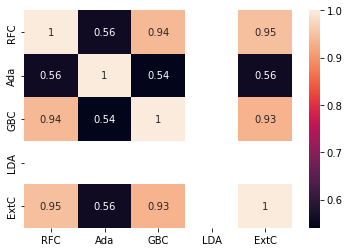

In [48]:
test_elected_RFC = pd.Series(RFC_best.predict(Test), name="RFC")
test_elected_AdaC = pd.Series(ada_best.predict(Test), name="Ada")
test_elected_GBC = pd.Series(GBC_best.predict(Test), name="GBC")
test_elected_LDA = pd.Series(LDA_best.predict(Test), name="LDA")
test_elected_ExtC = pd.Series(ExtC_best.predict(Test), name="ExtC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_elected_RFC,test_elected_AdaC,test_elected_GBC,test_elected_LDA,test_elected_ExtC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

#### 6.5. Ensemble modeling
***Combining models***

I choosed a voting classifier to combine the predictions coming from the 5 classifiers.
I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [49]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('adac',ada_best),('gbc',GBC_best),('extc',ExtC_best),('lda',LDA_best)], voting='soft')

votingC = votingC.fit(X_train, Y_train)

In [57]:
### saving the model
import joblib
joblib.dump(votingC, './models/emsemble_proj_interdisciplinar-01.pkl')

['./models/emsemble_proj_interdisciplinar-01.pkl']

#### 6.3 Prediction

In [ ]:
### loading the trained model, if needed
#votingC = joblib.load('./models/emsemble_proj_interdisciplinar-01.pkl')

In [ ]:
#Test = test_data.drop(labels = ["QT_VOTOS_NOMINAIS_x","DS_SIT_TOT_TURNO"],axis = 1)

In [50]:
test_elected = pd.Series(votingC.predict(Test), name="Eleitos")

In [51]:
from sklearn.metrics import accuracy_score

y_test = test_data["DS_SIT_TOT_TURNO"]
y_pred = test_elected
score = accuracy_score(y_test, y_pred)

In [52]:
score

0.925577156743621

In [54]:
results = pd.concat([test_data.SQ_CANDIDATO,test_elected],axis=1)

In [55]:
results

,SQ_CANDIDATO,Eleitos
0,160001717443,0
1,160001723054,0
2,250001621417,0
3,100001602261,1
4,50001605373,0
...,...,...
3287,80001645482,0
3288,140001651018,0
3289,170001604105,0
3290,20001612352,0


**170 candidatos foram considerados eleitos, com um score de acurácia de 0.925577156743621, o que parece aceitável**

In [56]:
results.to_csv("./datasets TSE/ensemble_python_voting.csv",index=False)

## 7. Análise adicional

Tendo em vista que os dados são desbalanceados, e o critério da acurácia não é a melhor forma, vamos fazer uma nova análise por ROC - AUC

### 7.1. Importando os dados:

In [5]:
#=======================================================================================
# Reading the data (from AWS S3)
#=======================================================================================
session = boto3.Session()
s3 = session.client('s3')

#s3_client = boto3.client("s3")
data_bucket_name = "syaguchi-aws-ifspcps-bucket-tse2022"
#obj_list = s3_client.list_objects(Bucket=data_bucket_name)
obj_list = s3.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)

['Proj_Int_2022.2/test/tse2022_test.csv', 'Proj_Int_2022.2/train/tse2022_train.csv', 'Proj_Int_2022.2/validate/tse2022_validate.csv', 'bem_candidato_2022_BRASIL.csv', 'consulta_cand_2022_BRASIL.csv', 'sagemaker-sklearn-artifact/sklearn-boto3-1-2022-11-28-03-55-02/output/model.tar.gz', 'sagemaker-sklearn-artifact/sklearn-boto3-1-2022-11-28-04-40-44/output/model.tar.gz', 'sagemaker/sklearn-tse2022/tse2022_test.csv', 'sagemaker/sklearn-tse2022/tse2022_train.csv', 'scikitlearn-tse-2022-train-from-boto3/source.tar.gz', 'scikitlearn-tse2022-train-from-boto3/source.tar.gz', 'test_df.csv/test_df.csv', 'train_df.csv/train_df.csv', 'votacao_candidato_munzona_2022_BRASIL_pre_merge13.csv']


In [6]:
file_data = 'votacao_candidato_munzona_2022_BRASIL_pre_merge13.csv'
response = s3.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
df = pd.read_csv(io.BytesIO(response_body), header=0, low_memory=True)

### 7.2 Exploratory Data Analysis (EDA):

In [7]:
df.head()

,ELEITO,SQ_CANDIDATO,CD_CARGO,NR_IDADE_DATA_POSSE,CD_GENERO,CD_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,CD_COR_RACA,CD_OCUPACAO,CD_REELEICAO,VR_BEM_CANDIDATO,QT_VOTOS_NOMINAIS
0,0,210001596986,6,450,4,8,1,1,265,0,1990000,1064
1,0,210001620062,6,630,2,6,1,1,169,0,32333075,1269
2,0,210001620186,7,470,2,8,3,1,131,0,47646146,11194
3,0,90001712199,7,600,2,7,3,1,257,0,12174939,4891
4,0,140001601525,7,360,4,8,1,1,101,0,355000,477


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16457 entries, 0 to 16456
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   ELEITO               16457 non-null  int64
 1   SQ_CANDIDATO         16457 non-null  int64
 2   CD_CARGO             16457 non-null  int64
 3   NR_IDADE_DATA_POSSE  16457 non-null  int64
 4   CD_GENERO            16457 non-null  int64
 5   CD_GRAU_INSTRUCAO    16457 non-null  int64
 6   CD_ESTADO_CIVIL      16457 non-null  int64
 7   CD_COR_RACA          16457 non-null  int64
 8   CD_OCUPACAO          16457 non-null  int64
 9   CD_REELEICAO         16457 non-null  int64
 10  VR_BEM_CANDIDATO     16457 non-null  int64
 11  QT_VOTOS_NOMINAIS    16457 non-null  int64
dtypes: int64(12)
memory usage: 1.5 MB


In [9]:
df.describe()

,ELEITO,SQ_CANDIDATO,CD_CARGO,NR_IDADE_DATA_POSSE,CD_GENERO,CD_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,CD_COR_RACA,CD_OCUPACAO,CD_REELEICAO,VR_BEM_CANDIDATO,QT_VOTOS_NOMINAIS
count,16457.000000,1.645700e+04,16457.000000,16457.000000,16457.000000,16457.000000,16457.000000,16457.000000,16457.000000,16457.000000,1.645700e+04,1.645700e+04
mean,0.092058,1.566681e+11,6.615908,494.488060,2.560856,7.241964,3.330680,1.816370,367.282251,0.074862,3.139414e+14,1.928758e+04
std,0.289117,7.283778e+10,0.553262,110.130826,0.898444,1.232029,2.421601,0.971178,299.622697,0.263176,2.802469e+15,1.500656e+05
min,0.000000,1.000160e+10,5.000000,200.000000,2.000000,2.000000,1.000000,1.000000,101.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,1.000016e+11,6.000000,420.000000,2.000000,6.000000,1.000000,1.000000,156.000000,0.000000,1.000000e+06,4.920000e+02
50%,0.000000,1.600016e+11,7.000000,490.000000,2.000000,8.000000,3.000000,1.000000,257.000000,0.000000,4.332161e+06,1.868000e+03
75%,0.000000,2.200016e+11,7.000000,570.000000,4.000000,8.000000,3.000000,3.000000,301.000000,0.000000,2.951314e+07,9.043000e+03
max,1.000000,2.700017e+11,8.000000,920.000000,4.000000,8.000000,9.000000,6.000000,999.000000,1.000000,6.479085e+16,1.071491e+07


In [10]:
print(df.isnull().sum())

ELEITO                 0
SQ_CANDIDATO           0
CD_CARGO               0
NR_IDADE_DATA_POSSE    0
CD_GENERO              0
CD_GRAU_INSTRUCAO      0
CD_ESTADO_CIVIL        0
CD_COR_RACA            0
CD_OCUPACAO            0
CD_REELEICAO           0
VR_BEM_CANDIDATO       0
QT_VOTOS_NOMINAIS      0
dtype: int64


Observamos que não há dados nulos 

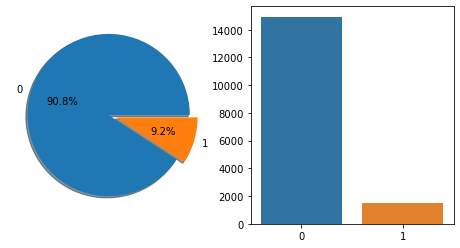

In [10]:
# ===================================================================
# Contagem dos eleitos
# ===================================================================


f,ax=plt.subplots(1,2,figsize=(8,4))
df['ELEITO'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x = df["ELEITO"], ax = ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.show()

Confirmando o desbalanceamento dos dados, tendo o target como 'ELEITO'.<br>
Apenas como comparação, Titanic teve 38,4% de sobreviventes (338 sobreviventes)

### 7.3 Treinamento e Validação de modelos: 

##### Setup incial

In [11]:
# Importing the libaries:

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#from catboost import CatBoostClassifier
#from xgboost import XGBClassifier
from sklearn import svm
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
#import xgboost as xgb

pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

##### Definir variáveis "preditores" e "target". Observa-se que não há variáveis categóricas nos dados.

In [12]:
target = 'ELEITO'
predictors = ['SQ_CANDIDATO', 'CD_CARGO', 'NR_IDADE_DATA_POSSE', 'CD_GENERO', 'CD_GRAU_INSTRUCAO',\
       'CD_ESTADO_CIVIL', 'CD_COR_RACA', 'CD_OCUPACAO', 'CD_REELEICAO', 'VR_BEM_CANDIDATO',\
       'QT_VOTOS_NOMINAIS']

In [13]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

#### 7.3.1 RandomForestClassifier

Usaremos critério de validação GINI, cuja fórmula é GINI = 2 * (AUC) - 1, onde AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC).
Nº de estimadores em 100 e nº de jobs paraleos em 4.

In [14]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, random_state=RANDOM_STATE, criterion=RFC_METRIC, n_estimators=NUM_ESTIMATORS, verbose=False)

In [15]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [16]:
preds = clf.predict(valid_df[predictors])

##### Analisando  importância das variáveis

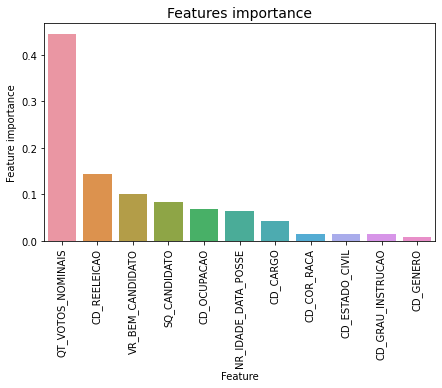

In [37]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

##### Analisando matriz de confusão

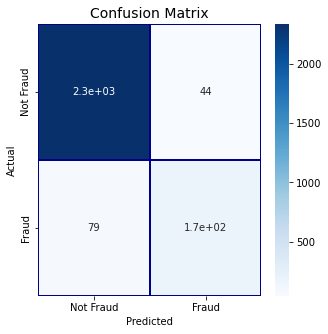

In [38]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Analisando score ROC-AUC

In [17]:
#Validation 
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [18]:
roc_auc_score(valid_df[target].values, preds)

0.8340141530502723

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [20]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [21]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(train_df[predictors], train_df[target].values)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.9567033559127172

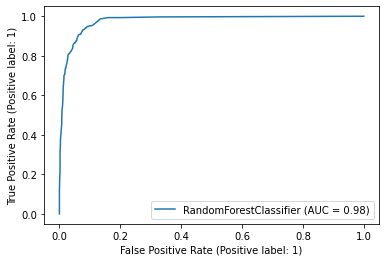

In [23]:
#Plot ROC Curve
plot_roc_curve(clf, test_df[predictors], test_df[target].values)

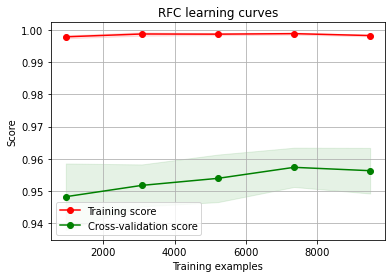

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
g = plot_learning_curve(gsRFC.best_estimator_,"RFC learning curves",train_df[predictors], train_df[target].values,cv=kfold)

Com ROC-AUC obtivemos melgoria na acurácia: 

0.956798592978226

## 8. Estudo AWS Endpoint

Neste trecho faremos um exercício com Sagemaker Endpoint.<br>
Para isso faremos um modelamento Random Forest para o qual será feito deploy.

#### 8.1 Setup

In [1]:
import datetime
import time
import tarfile

import boto3
import io
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing


sm_boto3 = boto3.client("sagemaker")

sess = sagemaker.Session()

region = sess.boto_session.region_name

#bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
bucket = 'syaguchi-aws-ifspcps-bucket-tse2022'  # hard-coded bucket name 

print("Using bucket " + bucket)

Using bucket syaguchi-aws-ifspcps-bucket-tse2022


#### 8.2 Preparação dos dados

In [2]:
#=======================================================================================
# Reading the data (from AWS S3)
#=======================================================================================
session = boto3.Session()
s3 = session.client('s3')

data_bucket_name = "syaguchi-aws-ifspcps-bucket-tse2022"
#obj_list = s3_client.list_objects(Bucket=data_bucket_name)
obj_list = s3.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)

['Proj_Int_2022.2/test/tse2022_test.csv', 'Proj_Int_2022.2/train/tse2022_train.csv', 'Proj_Int_2022.2/validate/tse2022_validate.csv', 'bem_candidato_2022_BRASIL.csv', 'consulta_cand_2022_BRASIL.csv', 'sagemaker-sklearn-artifact/sklearn-boto3-1-2022-11-28-03-55-02/output/model.tar.gz', 'sagemaker/sklearn-tse2022/tse2022_test.csv', 'sagemaker/sklearn-tse2022/tse2022_train.csv', 'scikitlearn-tse-2022-train-from-boto3/source.tar.gz', 'scikitlearn-tse2022-train-from-boto3/source.tar.gz', 'test_df.csv/test_df.csv', 'train_df.csv/train_df.csv', 'votacao_candidato_munzona_2022_BRASIL_pre_merge13.csv']


In [3]:
file_data = 'votacao_candidato_munzona_2022_BRASIL_pre_merge13.csv'
response = s3.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
data = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [4]:
target = 'ELEITO'
predictors = ['CD_CARGO', 'NR_IDADE_DATA_POSSE', 'CD_GENERO', 'CD_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL',\
              'CD_COR_RACA', 'CD_OCUPACAO','CD_REELEICAO','VR_BEM_CANDIDATO','QT_VOTOS_NOMINAIS']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data[predictors], data[target].values, test_size=0.25, random_state=42
)

#trainX = pd.DataFrame(X_train, columns=data.feature_names)
trainX = pd.DataFrame(X_train)
trainX["target"] = y_train

#testX = pd.DataFrame(X_test, columns=data.feature_names)
testX = pd.DataFrame(X_test)
testX["target"] = y_test

In [6]:
trainX.to_csv("tse2022_train.csv")
testX.to_csv("tse2022_test.csv")

In [7]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path="tse2022_train.csv", bucket=bucket, key_prefix="sagemaker/sklearn-tse2022"
)

testpath = sess.upload_data(
    path="tse2022_test.csv", bucket=bucket, key_prefix="sagemaker/sklearn-tse2022"
)

#### 8.3 Preparando um Script Mode script

O script abaixo contém treinamnento e inferência

In [8]:
%%writefile script.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor


# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


if __name__ == "__main__":

    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="tse2022_train.csv")
    parser.add_argument("--test-file", type=str, default="tse2022_test.csv")
    parser.add_argument(
        "--features", type=str
    )  # in this script we ask user to explicitly name features
    parser.add_argument(
        "--target", type=str
    )  # in this script we ask user to explicitly name the target

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print("building training and testing datasets")
    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print("training model")
    model = RandomForestRegressor(
        n_estimators=args.n_estimators, min_samples_leaf=args.min_samples_leaf, n_jobs=-1
    )

    model.fit(X_train, y_train)

    # print abs error
    print("validating model")
    abs_err = np.abs(model.predict(X_test) - y_test)

    # print couple perf metrics
    for q in [10, 50, 90]:
        print("AE-at-" + str(q) + "th-percentile: " + str(np.percentile(a=abs_err, q=q)))

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)

Overwriting script.py


#### 8.4 Treinamento SageMaker

Faremos um treinamento com boto3

In [9]:
# first compress the code and send to S3

source = "source.tar.gz"
project = "scikitlearn-tse2022-train-from-boto3"

tar = tarfile.open(source, "w:gz")
tar.add("script.py")
tar.close()

s3 = boto3.client("s3")
s3.upload_file(source, bucket, project + "/" + source)

In [10]:
# When using boto3 to launch a training job, we must explicitly point to a docker image.
from sagemaker import image_uris

FRAMEWORK_VERSION = "1.0-1"

training_image = image_uris.retrieve(
    framework="sklearn",
    region=region,
    version=FRAMEWORK_VERSION,
    py_version="py3",
    instance_type="ml.c5.xlarge",
)
print(training_image)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3


Rodando um modelo de treinamneto, e ao final os artefatos do modelo resultantes serão armazenados no local S3 especificado.

In [11]:
training_job_1_name = "sklearn-boto3-1-" + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

training_job_1_response = sm_boto3.create_training_job(
    TrainingJobName=training_job_1_name,
    HyperParameters={
        "n_estimators": "300",
        "min_samples_leaf": "3",
        "sagemaker_program": "script.py",
        "features": "CD_CARGO NR_IDADE_DATA_POSSE CD_GENERO CD_GRAU_INSTRUCAO CD_ESTADO_CIVIL CD_COR_RACA CD_OCUPACAO CD_REELEICAO VR_BEM_CANDIDATO QT_VOTOS_NOMINAIS",
        "target": "target",
        "sagemaker_submit_directory": "s3://" + bucket + "/" + project + "/" + source,
    },
    AlgorithmSpecification={
        "TrainingImage": training_image,
        "TrainingInputMode": "File",
        "MetricDefinitions": [
            {"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"},
        ],
    },
    RoleArn=get_execution_role(),
    InputDataConfig=[
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": trainpath,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
        },
        {
            "ChannelName": "test",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": testpath,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
        },
    ],
    OutputDataConfig={"S3OutputPath": "s3://" + bucket + "/sagemaker-sklearn-artifact/"},
    ResourceConfig={"InstanceType": "ml.c5.xlarge", "InstanceCount": 1, "VolumeSizeInGB": 10},
    StoppingCondition={"MaxRuntimeInSeconds": 86400},
    EnableNetworkIsolation=False,
)

training_job_1_response

{'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:887118459548:training-job/sklearn-boto3-1-2022-11-28-04-40-44',
 'ResponseMetadata': {'RequestId': '126d4dd2-bd0f-4b80-ab33-054a9919dfc6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '126d4dd2-bd0f-4b80-ab33-054a9919dfc6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '110',
   'date': 'Mon, 28 Nov 2022 04:40:44 GMT'},
  'RetryAttempts': 0}}

In [12]:
import boto3
import time

client = boto3.client("sagemaker")

training_job_1_details = client.describe_training_job(TrainingJobName=training_job_1_name)

while training_job_1_details["TrainingJobStatus"] == "InProgress":
    training_job_1_details = client.describe_training_job(TrainingJobName=training_job_1_name)
    print(training_job_1_details["TrainingJobStatus"])
    time.sleep(15)

training_job_1_details

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


{'TrainingJobName': 'sklearn-boto3-1-2022-11-28-04-40-44',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:887118459548:training-job/sklearn-boto3-1-2022-11-28-04-40-44',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://syaguchi-aws-ifspcps-bucket-tse2022/sagemaker-sklearn-artifact/sklearn-boto3-1-2022-11-28-04-40-44/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'features': 'CD_CARGO NR_IDADE_DATA_POSSE CD_GENERO CD_GRAU_INSTRUCAO CD_ESTADO_CIVIL CD_COR_RACA CD_OCUPACAO CD_REELEICAO VR_BEM_CANDIDATO QT_VOTOS_NOMINAIS',
  'min_samples_leaf': '3',
  'n_estimators': '300',
  'sagemaker_program': 'script.py',
  'sagemaker_submit_directory': 's3://syaguchi-aws-ifspcps-bucket-tse2022/scikitlearn-tse2022-train-from-boto3/source.tar.gz',
  'target': 'target'},
 'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3',
  'TrainingInputMode': 'File',
  'MetricDefi

#### 8.5 Creando Modelo para o job de treinamento


In [13]:
model_1_name = "sklearn-model-1-" + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

create_model_1_response = client.create_model(
    ModelName=model_1_name,
    PrimaryContainer={
        "Image": training_job_1_details["AlgorithmSpecification"]["TrainingImage"],
        "Mode": "SingleModel",
        "ModelDataUrl": training_job_1_details["ModelArtifacts"]["S3ModelArtifacts"],
        "Environment": {
            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
            "SAGEMAKER_PROGRAM": training_job_1_details["HyperParameters"]["sagemaker_program"],
            "SAGEMAKER_REGION": region,
            "SAGEMAKER_SUBMIT_DIRECTORY": training_job_1_details["HyperParameters"][
                "sagemaker_submit_directory"
            ],
        },
    },
    ExecutionRoleArn=get_execution_role(),
)

create_model_1_response

{'ModelArn': 'arn:aws:sagemaker:us-east-1:887118459548:model/sklearn-model-1-2022-11-28-04-43-46',
 'ResponseMetadata': {'RequestId': '99d1af3b-0eb3-40a5-a8cc-a689aa6531c2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '99d1af3b-0eb3-40a5-a8cc-a689aa6531c2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '97',
   'date': 'Mon, 28 Nov 2022 04:43:46 GMT'},
  'RetryAttempts': 0}}

In [14]:
client.describe_model(ModelName=model_1_name)

{'ModelName': 'sklearn-model-1-2022-11-28-04-43-46',
 'PrimaryContainer': {'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3',
  'Mode': 'SingleModel',
  'ModelDataUrl': 's3://syaguchi-aws-ifspcps-bucket-tse2022/sagemaker-sklearn-artifact/sklearn-boto3-1-2022-11-28-04-40-44/output/model.tar.gz',
  'Environment': {'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
   'SAGEMAKER_PROGRAM': 'script.py',
   'SAGEMAKER_REGION': 'us-east-1',
   'SAGEMAKER_SUBMIT_DIRECTORY': 's3://syaguchi-aws-ifspcps-bucket-tse2022/scikitlearn-tse2022-train-from-boto3/source.tar.gz'}},
 'ExecutionRoleArn': 'arn:aws:iam::887118459548:role/LabRole',
 'CreationTime': datetime.datetime(2022, 11, 28, 4, 43, 46, 466000, tzinfo=tzlocal()),
 'ModelArn': 'arn:aws:sagemaker:us-east-1:887118459548:model/sklearn-model-1-2022-11-28-04-43-46',
 'EnableNetworkIsolation': False,
 'ResponseMetadata': {'RequestId': 'a92fd732-9c0f-4144-bbc0-f52a11ecc584',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {

#### 8.6 Criando um Endpoint para o modelo

In [15]:
endpoint_config_1_name = "sklearn-endpoint-config-1-" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%M-%S"
)

endpoint_config_1_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_1_name,
    ProductionVariants=[
        {
            "VariantName": "AllTrafficVariant",
            "ModelName": model_1_name,
            "InitialInstanceCount": 1,
            "InstanceType": "ml.c5.large",
            "InitialVariantWeight": 1,
        },
    ],
)

endpoint_config_1_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:887118459548:endpoint-config/sklearn-endpoint-config-1-2022-11-28-04-43-56',
 'ResponseMetadata': {'RequestId': 'b1e152c3-5506-4e98-bd22-102c74ddb44a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b1e152c3-5506-4e98-bd22-102c74ddb44a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '126',
   'date': 'Mon, 28 Nov 2022 04:43:56 GMT'},
  'RetryAttempts': 0}}

#### 8.7 Deploy do modelo

In [16]:
endpoint_name = "sklearn-endpoint-" + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_1_name,
)

create_endpoint_response

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:887118459548:endpoint/sklearn-endpoint-2022-11-28-04-44-01',
 'ResponseMetadata': {'RequestId': '546d0c7a-5db0-4bda-9fdd-1efb641d1461',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '546d0c7a-5db0-4bda-9fdd-1efb641d1461',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '104',
   'date': 'Mon, 28 Nov 2022 04:44:01 GMT'},
  'RetryAttempts': 0}}

In [17]:
describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'sklearn-endpoint-2022-11-28-04-44-01',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:887118459548:endpoint/sklearn-endpoint-2022-11-28-04-44-01',
 'EndpointConfigName': 'sklearn-endpoint-config-1-2022-11-28-04-43-56',
 'ProductionVariants': [{'VariantName': 'AllTrafficVariant',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn@sha256:e7887de688db0abeb4ae7f0467d18c69c613d3795bc23c425ec0574b19b81350',
     'ResolutionTime': datetime.datetime(2022, 11, 28, 4, 44, 2, 735000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 11, 28, 4, 44, 2, 24000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 11, 28, 4, 45, 55, 536000, tzinfo=tzlocal()),

In [18]:
runtime = boto3.client("sagemaker-runtime")

#### 8.8 Clean-up

In [19]:
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '6fcd17d7-e4e7-42e4-9ba3-61aac25dc5d7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6fcd17d7-e4e7-42e4-9ba3-61aac25dc5d7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 28 Nov 2022 04:47:18 GMT'},
  'RetryAttempts': 0}}